In [1]:
# !pip install faiss
# !pip install haversine

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import faiss
import torch
import torch.nn.functional as F
from torch import tensor
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.sparse import csc_matrix
from copy import deepcopy
import time
from scipy.ndimage import gaussian_filter
from scipy.sparse import csr_matrix
from multiprocessing import Pool
import plotly.express as px
import matplotlib.pyplot as plt
from haversine import haversine_vector
import random
from functools import partial

In [3]:
import pickle 

def pkl_save(path, obj):
  with open(path, 'wb') as file:
    pickle.dump(obj, file)

def pkl_load(path):
  with open(path, 'rb') as file:
    return pickle.load(file)

In [4]:
def calc_threshs(errs):
    for thresh in [1, 25, 200, 750, 2500]:
        frac = (errs < thresh).mean()
        print(f"{thresh}:\t{frac:.5f}")
    return (errs < 200).mean()

In [5]:
root_dir = Path('.')

In [9]:
data = pd.read_csv(root_dir/"data.csv")
logits_country = pkl_load(root_dir/"logits_country")
logits_geocell = pkl_load(root_dir/"logits_geocell")
logits_us = pkl_load(root_dir/'logits_us')
logits_country.shape, logits_geocell.shape, logits_us.shape

(torch.Size([97068, 87]), torch.Size([97068, 275]), torch.Size([97068, 50]))

In [10]:
X = torch.cat([logits_country, logits_geocell, logits_us], 1).numpy()
y = np.array(data[["lat", "lng"]])
X.shape, y.shape

((97068, 412), (97068, 2))

In [11]:
tr_idx = data.index[data['set'] == 'train'].tolist()
vl_idx = data.index[data['set'] == 'valid'].tolist()
ts_idx = data.index[data['set'] == 'test'].tolist()
len(tr_idx), len(vl_idx), len(ts_idx)

(77654, 9707, 9707)

In [12]:
X_tr, X_vl, X_ts = X[tr_idx], X[vl_idx], X[ts_idx]
y_tr, y_vl, y_ts = y[tr_idx], y[vl_idx], y[ts_idx]

In [10]:
class FaissNeighbors:
    def __init__(self, k=5):
        self.index=None
        self.y=None
        self.k=k
    
    def fit(self, X):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
    
    def predict(self, X):
        # returns (distances, indices)
        return self.index.search(X.astype(np.float32), k=self.k)

In [11]:
from typing import NamedTuple

In [12]:
class Weights(NamedTuple):
    COUNTRY: float
    GEOCELL: float
    US: float

In [13]:
class Config(NamedTuple):
    K: int
    M: int
    SIGMA: int
    SCALE: int
    TRUNCATE: int
    US_THRESH: float
    WEIGHTS_WORLD: Weights
    WEIGHTS_US: Weights

In [14]:
def get_base_filter(config):
    half_width = int(config.TRUNCATE*config.SIGMA*config.SCALE)
    zs = np.zeros([2*half_width+1]*2)
    zs[half_width,half_width]=1
    return gaussian_filter(zs, sigma=config.SIGMA*config.SCALE, truncate=config.TRUNCATE)

In [15]:
def make_filter(config, main, base_filter, lat_lng, weight):        
    lat, lng = lat_lng
    # Rescale starting at zero
    lat += 90.0
    lng += 180.0
    # Get x and y indices
    lat_idx = round(lat*config.SCALE)
    lng_idx = round(lng*config.SCALE)
    # Make filter
    data = base_filter.copy() * weight
    
    # Put filter into sparse array of the same shape as "main"
    
    # b = "big", s = "small", c = "center"
    hb, wb = main.shape
    hs, ws = data.shape
    hc, wc = lat_idx, lng_idx
    
    # Get row and col indices
    row, col = np.meshgrid(range(hs), range(ws))
    row = row.T.flatten()
    col = col.T.flatten()

    # Re-center them
    row = row - hs // 2 + hc
    col = col - ws // 2 + wc
    
    # Remove out-of-bounds indices
    df = pd.DataFrame({'row': row, 'col': col, 'data': data.flatten()})
    df = df[(df.row >= 0) & (df.col >= 0) & (df.row < hb) & (df.col < wb)]
    
    # Return sparse matrix
    row, col, data = df.row.tolist(), df.col.tolist(), df.data.tolist()
    return csr_matrix((data, (row, col)), shape=main.shape)

In [16]:
def get_best_lat_lng(config, filts):
    lat_idx_max = filts.max(1).argmax()
    lng_idx_max = filts.max(0).argmax()
    lat_max = (lat_idx_max/config.SCALE) - 90
    lng_max = (lng_idx_max/config.SCALE) - 180
    return lat_max, lng_max

In [17]:
def _get_best_lat_lng(config, MAIN, BASE_FILTER, args):
    neighbor_locs, neighbor_weights = args
    main = deepcopy(MAIN)
    rows = []
    for lat_lng, weight in zip(neighbor_locs, neighbor_weights):
        main += make_filter(config=config, main=main, base_filter=BASE_FILTER, lat_lng=lat_lng, weight=weight)
    return get_best_lat_lng(config, main)

def predict(config, MAIN, BASE_FILTER, indices, weights, top=None):
    neighbor_locs_ls = y_tr[indices] # (num_valid, K, 2)
    args_ls = list(zip(neighbor_locs_ls, weights))
    if top is not None: # Used for testing
        args_ls = args_ls[:top]
    
    pool = Pool()
    fn = partial(_get_best_lat_lng, config, MAIN, BASE_FILTER)
    best_lat_lngs = pool.map(fn, args_ls)
    
    return np.array(best_lat_lngs)

In [18]:
def weight_x(weights, X):
    wc = np.ones(87) * weights.COUNTRY
    wg = np.ones(275) * weights.GEOCELL
    wu = np.ones(50) * weights.US
    w = np.concatenate([wc, wg, wu])
    return X * w

In [19]:
def get_is_us(config, X):
    country_logits = X[:,:87]
    country_exp = np.exp(country_logits)
    country_probs = country_exp / country_exp.sum(1, keepdims=True)
    us_probs = country_probs[:,83]
    return us_probs > config.US_THRESH

In [20]:
def combine(cond, x_t, x_f):
    t = np.where(cond)[0]
    f = np.where(~cond)[0]
    idxs = np.concatenate([t, f])
    reorder = [t[0] for t in sorted(enumerate(idxs), key=lambda t: t[1])]
    return np.concatenate([x_t,x_f], 0)[reorder]

In [21]:
def run_experiment(config):
    print(config)
    
    is_us_vl = get_is_us(config, X_vl)
    
    def predict_best_lat_lngs(weights, cond):
        # Re-weight both train and valid data
        X_tr_ = weight_x(weights, X_tr)
        X_vl_ = weight_x(weights, X_vl)[cond]
        
        fn = FaissNeighbors(k=config.K)
        fn.fit(X_tr_) 
        distances, indices = fn.predict(X_vl_)

        weights = (1/distances)**config.M
        weights /= weights.sum(1, keepdims=True)

        MAIN = csr_matrix((180*config.SCALE, 360*config.SCALE))
        BASE_FILTER = get_base_filter(config)

        return predict(config, MAIN, BASE_FILTER, indices, weights)

    best_lat_lngs_us = predict_best_lat_lngs(config.WEIGHTS_US, is_us_vl)
    best_lat_lngs_world = predict_best_lat_lngs(config.WEIGHTS_WORLD, ~is_us_vl)
    best_lat_lngs = combine(is_us_vl, best_lat_lngs_us, best_lat_lngs_world)

    # See the accuracy
    actual = y_vl
    errs = haversine_vector(best_lat_lngs, actual)
    return calc_threshs(errs)

In [22]:
### COMPARING VALUES OF SIGMA ###

In [23]:
# BEFORE NIGHT RUN:
# - Ensure SCALE = 60

In [24]:
def get_config(sigma):
    return Config(
        K = 20,
        M = 5,
        SIGMA = sigma,
        SCALE = 60,  # FINAL: 100
        TRUNCATE = 2,
        US_THRESH = 0.9,
        WEIGHTS_WORLD = Weights(COUNTRY=1., GEOCELL=1., US=0.),
        WEIGHTS_US = Weights(COUNTRY=1., GEOCELL=0.9, US=1.1),
    )

In [25]:
run_experiment(get_config(1))

Config(K=20, M=5, SIGMA=1, SCALE=60, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=1.0, GEOCELL=1.0, US=0.0), WEIGHTS_US=Weights(COUNTRY=1.0, GEOCELL=0.9, US=1.1))
1:	0.00587
25:	0.09354
200:	0.35830
750:	0.69177
2500:	0.87061


0.35829813536623056

In [ ]:
run_experiment(get_config(8))

Config(K=20, M=5, SIGMA=8, SCALE=60, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=1.0, GEOCELL=1.0, US=0.0), WEIGHTS_US=Weights(COUNTRY=1.0, GEOCELL=0.9, US=1.1))


In [ ]:
run_experiment(get_config(16))

In [ ]:
run_experiment(get_config(0.5))

In [ ]:
### FINDING BEST WORLD + US WEIGHTS ###

In [ ]:
def get_config(weights_world, weights_us):
    return Config(
        K = 20, # 20 FINAL
        M = 5,
        SIGMA = 4,
        SCALE = 10, # 10 FINAL
        TRUNCATE = 2,
        US_THRESH = 0.9,
        WEIGHTS_WORLD = weights_world,
        WEIGHTS_US = weights_us,
    )

In [24]:
# BEFORE NIGHT RUN:
# - Ensure config vals are FINAL
# - Ensure step val is FINAL

In [25]:
STEP = 0.1 # 0.1 FINAL

In [26]:
best_gc_val = 0. - STEP
best_gc_score = 0.
while True:
    gc_val = best_gc_val + STEP
    c = get_config(
        weights_world=Weights(0,0,0),
        weights_us=Weights(COUNTRY=1, GEOCELL=gc_val, US=0.),
    )
    gc_score = run_experiment(c)
    if gc_score < best_gc_score:
        break
    best_gc_val = gc_val
    best_gc_score = gc_score

print("BEST GC:", best_gc_val, "=>", best_gc_score)

Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.0, US=0.0))
1:	0.00000
25:	0.00787
200:	0.14492
750:	0.53180
2500:	0.88787
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.1, US=0.0))
1:	0.00000
25:	0.00721
200:	0.15934
750:	0.55672
2500:	0.89967
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.2, US=0.0))
1:	0.00000
25:	0.00852
200:	0.19279
750:	0.61902
2500:	0.91803
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.30000000000000004, US=0.0))
1:	0.00000
25:	0.01508
200:	0.23344
750:	0.68066
2500:	0.92787
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, 

In [27]:
best_us_val = 0. - STEP
best_us_score = 0.
while True:
    us_val = best_us_val + STEP
    c = get_config(
        weights_world=Weights(0,0,0),
        weights_us=Weights(COUNTRY=1, GEOCELL=best_gc_val, US=us_val),
    )
    us_score = run_experiment(c)
    if us_score < best_us_score:
        break
    best_us_val = us_val
    best_us_score = us_score

print("BEST US:", best_us_val, "=>", best_us_score)

Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.8999999999999999, US=0.0))
1:	0.00066
25:	0.02230
200:	0.31672
750:	0.75541
2500:	0.94426
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.8999999999999999, US=0.1))
1:	0.00066
25:	0.02098
200:	0.31869
750:	0.75803
2500:	0.94426
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.8999999999999999, US=0.2))
1:	0.00066
25:	0.02230
200:	0.32066
750:	0.76000
2500:	0.94557
Config(K=20, M=5, SIGMA=4, SCALE=10, TRUNCATE=2, US_THRESH=0.9, WEIGHTS_WORLD=Weights(COUNTRY=0, GEOCELL=0, US=0), WEIGHTS_US=Weights(COUNTRY=1, GEOCELL=0.8999999999999999, US=0.30000000000000004))
1:	0.00066
25:	0.02361
200:	0.32721
750:	0.76459
2500:	0.94754
Conf

In [24]:
plt.rcParams.update({'font.size': 10})

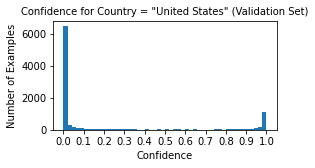

In [32]:
country_logits = X_vl[:,:87]
country_exp = np.exp(country_logits)
country_probs = country_exp / country_exp.sum(1, keepdims=True)
us_probs = country_probs[:,83]

plt.figure(figsize=(4,2))
plt.hist(country_probs[:,83], bins=50)
plt.xticks(np.arange(0,1.01, 0.1))
plt.title('Confidence for Country = "United States" (Validation Set)', fontsize=10)
plt.xlabel("Confidence")
plt.ylabel("Number of Examples")
plt.show()
# 0.9 looks like a pretty good thresh for US probs